# Unsupervised Learning 1 (Hyperparameter Tuning)

> k-means clustering, hierarchical clustering (maximum distances and variance minimization).

- toc: true 
- badges: true
- comments: true
- categories: [k-means clustering, hierarchical clustering, maximum distances, variance minimization, Elbow Method, Silhouette Method, Dendograms, optimal number of clusters]
- image: images/unsupervised_methods_1.png

## 1) Import libraries and define functions

### 1.1) Import libraries

In [ ]:
import re
import bs4
import ast
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display
from bs4 import BeautifulSoup
from matplotlib import pyplot
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()

## 2) Exploratory Data Analysis (EDA)

The data used in this analysis is obtained using web scraping, which was used to extract data regarding soccer players from the FIFA website https://sofifa.com/. Since the main purpose of the script is not to show how data scraping works, the explanation for this part will be concise. 

### 2.1) Identify the URL of the pages that display the top players

We will consider solely players with an overall rating of 75 or greater. 

In [ ]:
# Create list with the URL of the pages with the top players
offset_list = [''] + [str(i) for i in list(range(60,1861,60))]
url_top_players_list = ['https://sofifa.com/players?type=all&oal=75&offset=' + i for i in offset_list]

# Display some examples of URL pages where you can find top players
url_top_players_list[:2]

['https://sofifa.com/players?type=all&oal=75&offset=',
 'https://sofifa.com/players?type=all&oal=75&offset=60']

### 2.2) Identify the URL tof the pages with information for each player

In [ ]:
url_each_player_list =[]   

for url in url_top_players_list:
    page=requests.get(url)
    soup=BeautifulSoup(page.content,'html.parser')
    for link in soup.find_all('a'):
        if link.get('href') is not None:
            url_each_player_list.append(link.get('href'))
url_each_player_list = ['http://sofifa.com'+l for l in url_each_player_list if 'player/'in l]

### 2.3) Determine which attributes we seek to analyze

In [ ]:
attributes=['Crossing','Finishing','Heading Accuracy', 'Short Passing','Volleys','Dribbling','Curve','FK Accuracy','Long Passing','Ball Control','Acceleration',
 'Sprint Speed','Agility','Reactions','Balance','Shot Power','Jumping','Stamina','Strength','Long Shots','Aggression','Interceptions','Positioning','Vision','Penalties',
 'Composure','Defensive Awareness','Standing Tackle','Sliding Tackle','GK Diving','GK Handling','GK Kicking','GK Positioning','GK Reflexes']

### 2.4) Extract the information for each one of the players

In [ ]:
dictionary_of_dictionaries = {}
for link in url_each_player_list:
    response = requests.get(link)
    soup  = bs4.BeautifulSoup(response.text, 'html.parser')
    processing_items_1 =  soup.find_all('div', {'class': "card"})
    processing_items_2 = []
    for i in processing_items_1:
        processing_items_2.append(i.find_all('li'))
    list_strings = []
    for j in processing_items_2:
        for k in range(0,len(processing_items_2)):
            try: 
                list_strings.append(j[k].text)
            except:
                continue 
                
    dictionary_values = {}
    for item in attributes:
        try:
            matching = [s for s in list_strings if item in s]
            dictionary_values[item] = [int(s) for s in matching[0].split() if s.isdigit()][0]
        except:
            continue
    dictionary_of_dictionaries[link.split('/')[5]] = dictionary_values

### 2.5) Turn extracted features into data frames

In [ ]:
list_dfs = []
for player in dictionary_of_dictionaries:
  df = pd.DataFrame(dictionary_of_dictionaries[player], index=[player,])
  list_dfs.append(df)
player_data_df = pd.concat(list_dfs)
player_data_df.index.rename('Player', inplace=True)

### 2.6) Extract information regarding player position

In [ ]:
player_positions_dict = {}
for link in url_each_player_list:
    response = requests.get(link)
    soup  = bs4.BeautifulSoup(response.text, 'html.parser')
    processing_items_1 =  soup.find_all('div', {'class': "meta ellipsis"})
    processing_items_2 = []
    for i in processing_items_1:
        processing_items_2.append(i.find_all('span'))
    list_strings = []
    for j in processing_items_2:
        for k in range(0,len(str(processing_items_2[0]).split(','))):
            try: 
              position_raw = j[k].text
              if position_raw in ['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM']:
                position = 'Forward'
              elif position_raw in ['LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB']:
                position = 'Midfielder/Defender'
              elif position_raw in ['LB','LCB','CB','RCB','RB']:
                position = 'Midfielder/Defender'
              elif position_raw in ['GK']:
                position = 'Goal Keeper'           
              list_strings.append(position)
            except:
                continue 

    player_positions_dict[link.split('/')[5]] = list_strings

### 2.7) Map the player position information to the data frame

In [ ]:
player_data_df['Position'] = player_data_df.index.map(player_positions_dict)
player_data_df.dropna(inplace=True)
player_data_df[['Position']].head(2)

,Position
Player,
kylian-mbappe,"[Forward, Forward]"
kevin-de-bruyne,"[Midfielder/Defender, Forward]"


Notice that a player can receive multiple labels for his position. A player can be classified as a "striker" for one team and as a "left wing" for the national team. These 2 positions were encoded as "Forward" in part 2.6. This explains why the table above contains repetitions of labels such as ["Midfielder", "Midfielder"]. The following pirce of code extracts the most common position for the player. 

In [ ]:
player_data_df['Position'] = player_data_df['Position'].apply(lambda list_words: Counter(list_words).most_common(1)[0][0])

### 2.8) Export the data frame to avoid web scraping at every run

In [ ]:
player_data_df.to_csv('data_players.csv', encoding='utf-8')

### 2.9) Import the dataframe from the Github repository

In [ ]:
player_data_df = pd.read_csv('https://raw.githubusercontent.com/leonardodecastro/data/main/data_players.csv', sep =',',encoding='utf-8').set_index('Position')
player_data_df.head(2)

,Player,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,...,Penalties,Composure,Defensive Awareness,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
Position,,,,,,,,,,,,,,,,,,,,,
Forward,kylian-mbappe,78,93,72,85,83,93,80,69,71,...,80,88,26,34,32,13,5,7,11,6
Midfielder/Defender,kevin-de-bruyne,94,85,55,93,83,88,89,83,93,...,83,89,65,65,53,15,13,5,10,13


## 3) Split and scale data

We do not have to split the dataset since this script regards unsupervised learning. Therefore, there is no target variable. Moreover, scaling is not required since the features are all in the same scale (between 0 and 100)

##4) Determine the ideal number of clusters (K-means)

There are 2 common methods to determine the ideal number of clusters:
- The "Elbow Method"
- The "Silhouette Method"

### 4.1) Determine the number of clusters with the Elbow Method

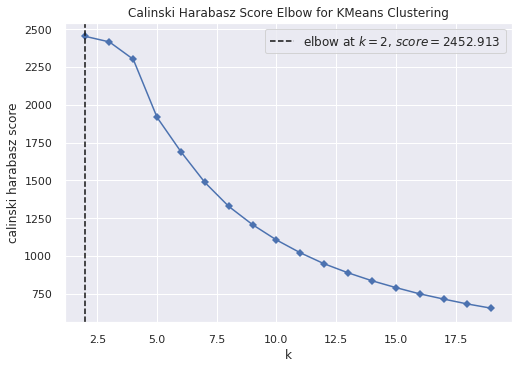

In [ ]:
# This line will disappear in the portfolio page
# Get rid of the names of the players since this information is not relevant for the cluster analysis
df_just_attributes = player_data_df.drop('Player', axis = 1)

# Use the visualizer to run the Elbow method
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, metric='calinski_harabasz', k=(2,20), timings=False)   
visualizer.fit(df_just_attributes)        # Fit the data to the visualizer
visualizer.show()   
plt.show()

### 4.2) Determine the number of clusters with the Silhouette Method

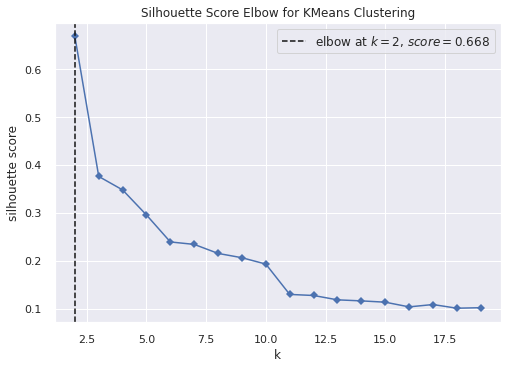

In [ ]:
# This line will disappear in the portfolio page
# Use the visualizer to run the Silhouette Method
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, metric='silhouette', k=(2,20), timings=False)   
visualizer.fit(df_just_attributes)        # Fit the data to the visualizer
visualizer.show()   
plt.show()

### 4.3) Interpret the results of the optimal number of clusters

The result is that the optimal number of clusters would be two. This might make intuitive sense. After all, goal keepers have a very different profile from other players. Let's see if this theory is true.


In [ ]:
# This line will disappear in the portfolio page
# Run K-means with 2 clusters 
kmeans = KMeans(n_clusters=2,random_state=42).fit(df_just_attributes)
df_just_attributes['cluster_label'] = kmeans.fit_predict(df_just_attributes)

# Check which cluster labels were assigned for goal keepers
df_just_attributes[df_just_attributes.index == 'Goal Keeper'][['cluster_label']].head(2)

,cluster_label
Position,
Goal Keeper,1
Goal Keeper,1


In [ ]:
# Create a feature that distinguishes between goal keepers and other players
df_just_attributes['Goal Keeper?'] = np.where(df_just_attributes.index == 'Goal Keeper',1,0)

# Determine the accuracy of the clustering method
accuracy_results = 100*accuracy_score(df_just_attributes['Goal Keeper?'], df_just_attributes['cluster_label'])
print('Accuracy of the prediction using clusters: ', accuracy_results, '%')

Accuracy of the prediction using clusters:  100.0 %


##5) Determine the ideal number of clusters (Hierarchical Clustering)

### 5.1) Determine the number of clusters using a dendogram

**Dendograms should not be used as a definite method for determining the number of clusters.** However, this visualization provides some insights into the possible clusters. We use the method "Ward" and the metric "Euclidian". However, there are different metrics and methods that can be used, as detailed below:
- Method: single, complete, average, weighted, centroid, median, ward
- Metric: euclidean, minkowski, cityblock, seuclidean, sqeuclidean, cosine, correlation, hamming, jaccard, jensenshannon, chebyshev, canberra, braycurtis, mahalanobis, yule, matching, dice, kulczynski1, rogerstanimoto,russellrao, sokalmichener, sokalsneath, kulczynski1

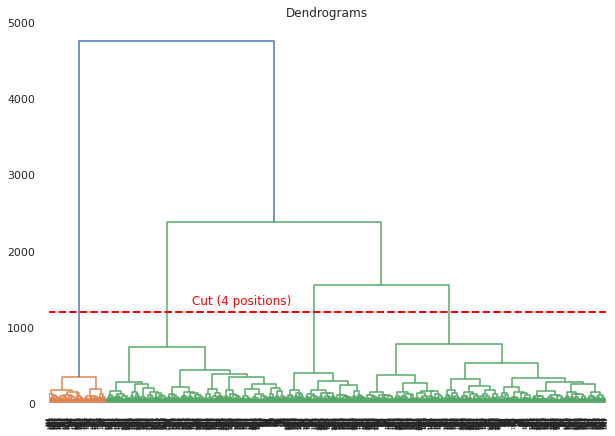

In [ ]:
# This line will disappear in the portfolio page
# Get rid of the names of the players since this information is not relevant for the cluster analysis
df_just_attributes = player_data_df.drop('Player', axis = 1)

# Dendogram for Heirarchical Clustering
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_just_attributes, method='ward', metric='euclidean'))

# Add horizontal line.
plt.axhline(y=1200, c='red', lw=2, linestyle='dashed')
plt.text(4500,1300,'Cut (4 positions)', c='red')
plt.show()

- Once again the **distiction between 2 groups is very stark** (Goal Keepers in Orange VS Other players in Green).
- This dendrogram suggests that a **"small" number of clusters between 2 and 6 would be ideal** to deal with this dataset. 

### 5.2) Interpret the results of the optimal number of clusters

**We can apply 2 hierarchical clustering technique to see if our intepretation of the dendogram is correct.**

#### 5.2.1) Run the first hierarchical clustering algorithm (maximum distances)

In [ ]:
# The argument linkage = 'complete' uses the maximum distances between all observations of the two sets.
df_just_attributes['cluster_label'] = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete').fit_predict(df_just_attributes)

# Check which cluster labels were assigned for goal keepers
df_just_attributes[df_just_attributes.index == 'Goal Keeper'][['cluster_label']].head(2)

,cluster_label
Position,
Goal Keeper,1
Goal Keeper,1


In [ ]:
# Create a feature that distinguishes between goal keepers and other players
df_just_attributes['Goal Keeper?'] = np.where(df_just_attributes.index == 'Goal Keeper',1,0)

# Determine the accuracy of the clustering method
accuracy_results = 100*accuracy_score(df_just_attributes['Goal Keeper?'], df_just_attributes['cluster_label'])
print('Accuracy of the prediction using clusters: ', accuracy_results, '%')

Accuracy of the prediction using clusters:  100.0 %


#### 5.2.2) Run the second hierarchical clustering algorithm (variance minimization)

In [ ]:
# This line will disappear in the portfolio page
# Get rid of the names of the players since this information is not relevant for the cluster analysis
df_just_attributes = player_data_df.drop('Player', axis = 1)

# The argument linkage = 'complete' uses the maximum distances between all observations of the two sets.
df_just_attributes['cluster_label'] = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit_predict(df_just_attributes)

# Check which cluster labels were assigned for goal keepers
df_just_attributes[df_just_attributes.index == 'Goal Keeper'][['cluster_label']].head(2)

,cluster_label
Position,
Goal Keeper,1
Goal Keeper,1


In [ ]:
# Create a feature that distinguishes between goal keepers and other players
df_just_attributes['Goal Keeper?'] = np.where(df_just_attributes.index == 'Goal Keeper',1,0)

# Determine the accuracy of the clustering method
accuracy_results = 100*accuracy_score(df_just_attributes['Goal Keeper?'], df_just_attributes['cluster_label'])
print('Accuracy of the prediction using clusters: ', accuracy_results, '%')

Accuracy of the prediction using clusters:  100.0 %


## 6) Consider PCA for dimensionality reduction

### 6.1 ) Why PCA is appropriate in this analysis. 

This technique is appropriate in this case since many of the features are highly correlated. In fact, FIFA's website automatically classifies many similar features into categories. For instance, it would be logical to use this technique to reduce the number of features in the category "Attacking". The same goes for each one of the 7 categories that are used to classify the 34 features.  

### 6.2) Why we did not display the PCA analysis here

Our experiments using PCA led to results that were very similar to using domain knowledge to reduce the number of features. Since this second approach leads to an analysis that is easier to interpret, we will only show this simpler option. Other posts will cover PCA in contexts in which it actually leads to increases in performance.  

## 7) Use domain knowledge for dimensionality reduction

### 7.1) Create new features as means of the variables of each type

In [ ]:
player_data_df['Attacking Feature'] = player_data_df[['Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing','Volleys']].mean(axis=1)
player_data_df['Skill Feature'] = player_data_df[['Dribbling', 'Curve', 'FK Accuracy', 'Long Passing','Ball Control']].mean(axis=1)
player_data_df['Movement Feature'] = player_data_df[['Acceleration', 'Sprint Speed', 'Agility', 'Reactions','Balance']].mean(axis=1)
player_data_df['Power Feature'] = player_data_df[['Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots']].mean(axis=1)
player_data_df['Mentality Feature'] = player_data_df[['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure']].mean(axis=1)
player_data_df['Defending Feature'] = player_data_df[['Defensive Awareness', 'Standing Tackle', 'Sliding Tackle']].mean(axis=1)
player_data_df['Goalkeeping Feature'] = player_data_df[['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning','GK Reflexes']].mean(axis=1)

### 7.2) Delete the original features

In [ ]:
player_data_df.drop(attributes,axis=1, inplace = True)
player_data_df.drop('Player',axis=1, inplace = True)

## 8) Apply clustering techniques with 3 clusters 

We will consider 3 clusters to make it easier to compare with the 3 selected categories (goalkeepers, midfielders/defenders & forwards).

### 8.1) Apply k-means

In [ ]:
# This line will disappear in the portfolio page
# Get rid of the names of the players since this information is not relevant for the cluster analysis
k_means_df = player_data_df.copy()

# Run K-means with 2 clusters 
kmeans = KMeans(n_clusters=3,random_state=42).fit(k_means_df)
k_means_df['Cluster Label'] = kmeans.fit_predict(k_means_df)

# Check which cluster labels were assigned for each position
df1 =  k_means_df[k_means_df.index=='Forward'][['Cluster Label']].head(5) 
df2 =  k_means_df[k_means_df.index=='Midfielder/Defender'][['Cluster Label']].head(5) 
df3 =  k_means_df[k_means_df.index=='Goal Keeper'][['Cluster Label']].head(5) 

pd.concat([df1.reset_index(),df2.reset_index(),df3.reset_index()], axis=1)

,Position,Cluster Label,Position,Cluster Label,Position,Cluster Label
0,Forward,2,Midfielder/Defender,0,Goal Keeper,1
1,Forward,2,Midfielder/Defender,0,Goal Keeper,1
2,Forward,2,Midfielder/Defender,0,Goal Keeper,1
3,Forward,2,Midfielder/Defender,0,Goal Keeper,1
4,Forward,2,Midfielder/Defender,0,Goal Keeper,1


Determine the accuracy of the clustering technique

In [ ]:
# Create a feature that distinguishes between goal keepers and other players
k_means_df['Cluster Label'] = k_means_df['Cluster Label'].map({2:'Forward',0:'Midfielder/Defender',1:'Goal Keeper'})

# Determine the accuracy of the clustering method
accuracy_results = round((100*accuracy_score(k_means_df.index, k_means_df['Cluster Label'])),1)
print('Accuracy of the prediction using clusters: ', accuracy_results, '%')

Accuracy of the prediction using clusters:  89.9 %


### 8.2) Run the first hierarchical clustering algorithm (maximum distances)

In [ ]:
# This line will disappear in the portfolio page
# Get rid of the names of the players since this information is not relevant for the cluster analysis
hier_clustering_df_1 = player_data_df.copy()

# The argument linkage = 'complete' uses the maximum distances between all observations of the two sets.
hier_clustering_df_1['Cluster Label'] = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete').fit_predict(hier_clustering_df_1)

# Check which cluster labels were assigned for each position
df1 =  hier_clustering_df_1[hier_clustering_df_1.index=='Forward'][['Cluster Label']].head(5) 
df2 =  hier_clustering_df_1[hier_clustering_df_1.index=='Midfielder/Defender'][['Cluster Label']].head(5) 
df3 =  hier_clustering_df_1[hier_clustering_df_1.index=='Goal Keeper'][['Cluster Label']].head(5) 

pd.concat([df1.reset_index(),df2.reset_index(),df3.reset_index()], axis=1)

,Position,Cluster Label,Position,Cluster Label,Position,Cluster Label
0,Forward,2,Midfielder/Defender,0,Goal Keeper,1
1,Forward,2,Midfielder/Defender,0,Goal Keeper,1
2,Forward,2,Midfielder/Defender,0,Goal Keeper,1
3,Forward,2,Midfielder/Defender,0,Goal Keeper,1
4,Forward,2,Midfielder/Defender,0,Goal Keeper,1


Determine the accuracy of the clustering technique

In [ ]:
# Create a feature that distinguishes between goal keepers and other players
hier_clustering_df_1['Cluster Label'] = hier_clustering_df_1['Cluster Label'].map({2:'Forward',0:'Midfielder/Defender',1:'Goal Keeper'})

# Determine the accuracy of the clustering method
accuracy_results = round((100*accuracy_score(hier_clustering_df_1.index, hier_clustering_df_1['Cluster Label'])),1)
print('Accuracy of the prediction using clusters: ', accuracy_results, '%')

Accuracy of the prediction using clusters:  86.8 %


### 8.3) Run the second hierarchical clustering algorithm (variance minimization)

In [ ]:
# This line will disappear in the portfolio page
# Get rid of the names of the players since this information is not relevant for the cluster analysis
hier_clustering_df_2 = player_data_df.copy()

# The argument linkage = 'complete' uses the maximum distances between all observations of the two sets.
hier_clustering_df_2['Cluster Label'] = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit_predict(hier_clustering_df_2)

# Check which cluster labels were assigned for each position
df1 =  hier_clustering_df_2[hier_clustering_df_2.index=='Forward'][['Cluster Label']].head(5) 
df2 =  hier_clustering_df_2[hier_clustering_df_2.index=='Midfielder/Defender'][['Cluster Label']].head(5) 
df3 =  hier_clustering_df_2[hier_clustering_df_2.index=='Goal Keeper'][['Cluster Label']].head(5) 

pd.concat([df1.reset_index(),df2.reset_index(),df3.reset_index()], axis=1)

,Position,Cluster Label,Position,Cluster Label,Position,Cluster Label
0,Forward,2,Midfielder/Defender,2,Goal Keeper,1
1,Forward,2,Midfielder/Defender,0,Goal Keeper,1
2,Forward,2,Midfielder/Defender,0,Goal Keeper,1
3,Forward,2,Midfielder/Defender,0,Goal Keeper,1
4,Forward,2,Midfielder/Defender,0,Goal Keeper,1


Determine the accuracy of the clustering technique

In [ ]:
# Create a feature that distinguishes between goal keepers and other players
hier_clustering_df_2['Cluster Label'] = hier_clustering_df_2['Cluster Label'].map({2:'Forward',0:'Midfielder/Defender',1:'Goal Keeper'})

# Determine the accuracy of the clustering method
accuracy_results = round((100*accuracy_score(hier_clustering_df_2.index, hier_clustering_df_2['Cluster Label'])),1)
print('Accuracy of the prediction using clusters: ', accuracy_results, '%')

Accuracy of the prediction using clusters:  89.4 %


## 9) Visualize the results of the clustering methods (2D)

### 9.1) Bring together the results of all algorithms

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Create a column in the original dataset to allow for merging it with the dataframes with the data about the clustering algorithms
player_data_df['Cluster Label'] = player_data_df.index

# Step 2: Create a column with the name of each clustering algorithm
player_data_df['Algorithm'] = 'Actual Labels (Source of Truth)'
k_means_df['Algorithm'] = 'K-Means Clustering'

hier_clustering_df_1['Algorithm'] = 'Hierar. Clustering (Max. distance)'
hier_clustering_df_2['Algorithm'] = 'Hierar. Clustering (Variance min.)'

# Step 3: Merge the dataframes with 
all_algorithms_df = pd.concat([k_means_df, hier_clustering_df_1, hier_clustering_df_2,player_data_df]).reset_index()

### 9.2) Create visualizations for 2 features at a time

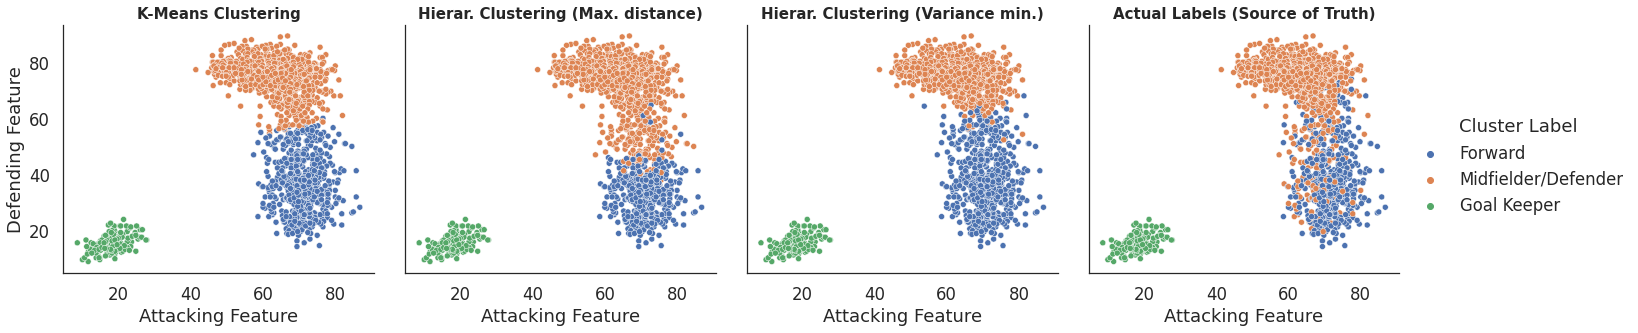

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.relplot(data=all_algorithms_df , x='Attacking Feature', y='Defending Feature', col = 'Algorithm', hue="Cluster Label", kind="scatter").set_titles(col_template='{col_name}', size = 15, weight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

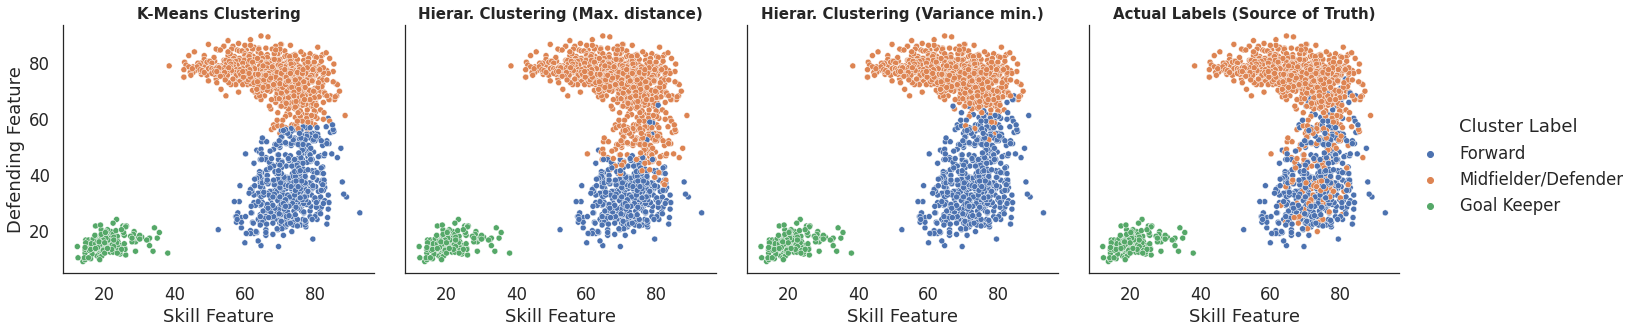

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.relplot(data=all_algorithms_df , x='Skill Feature', y='Defending Feature', col = 'Algorithm', hue="Cluster Label", kind="scatter").set_titles(col_template='{col_name}', size = 15, weight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

## 10) Visualize the results of the clustering methods (3D)

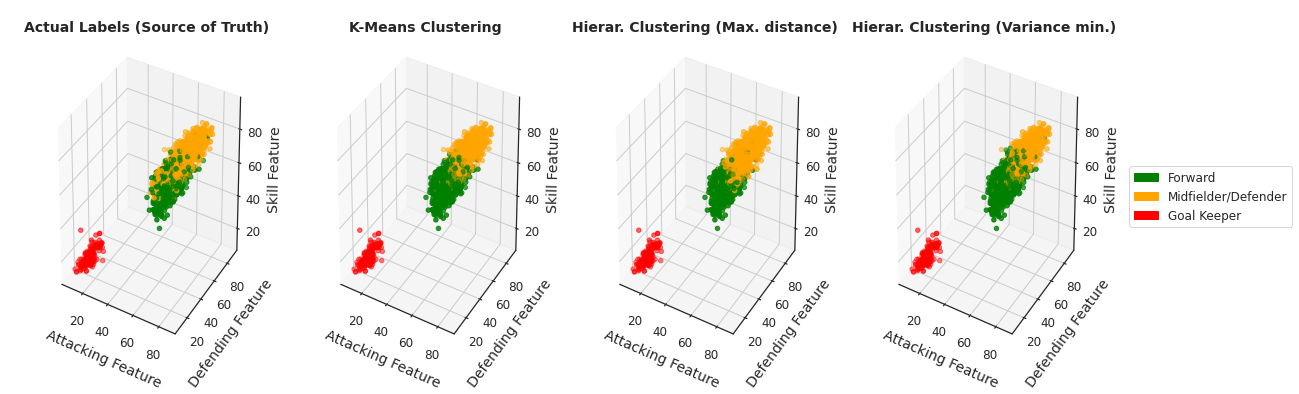

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Create a custom legend
green_patch = mpatches.Patch(color='green', label='Forward')
orange_patch = mpatches.Patch(color='orange', label='Midfielder/Defender')
red_patch = mpatches.Patch(color='red', label='Goal Keeper')

# Step 2: Map colors to each cluster label
all_algorithms_df['color'] = all_algorithms_df['Cluster Label'].map({'Forward':'green','Midfielder/Defender':'orange','Goal Keeper':'red'})

# Step 3: Create the subplots, one by one 
fig, ax = plt.subplots(1,4,figsize=(20,7),subplot_kw=dict(projection='3d'))
algorithm_list = ['Actual Labels (Source of Truth)', 'K-Means Clustering','Hierar. Clustering (Max. distance)','Hierar. Clustering (Variance min.)']

for i in range(0,len(algorithm_list)):
  df = all_algorithms_df[all_algorithms_df['Algorithm']==algorithm_list[i]]
  x,y,z,c =  df['Attacking Feature'], df['Defending Feature'], df['Skill Feature'], df['color']
  ax[i].scatter(x,y,z, c = c)
  ax[i].set_title(algorithm_list[i], fontsize = 14, weight='bold')
  ax[i].set_xlabel('Attacking Feature', fontsize = 14, labelpad=15)
  ax[i].set_ylabel('Defending Feature', fontsize = 14, labelpad=15)
  ax[i].set_zlabel('Skill Feature', fontsize = 14, labelpad=15)
  ax[i].tick_params(labelsize=12)
  ax[i].dist = 12
plt.subplots_adjust(wspace=0, hspace=0)
plt.legend(handles=[green_patch, orange_patch, red_patch], loc='center left', bbox_to_anchor=(1, 0.5),frameon=True,fontsize=12)
plt.show()